<a href="https://colab.research.google.com/github/pei0217/fin_hw3/blob/main/fin_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

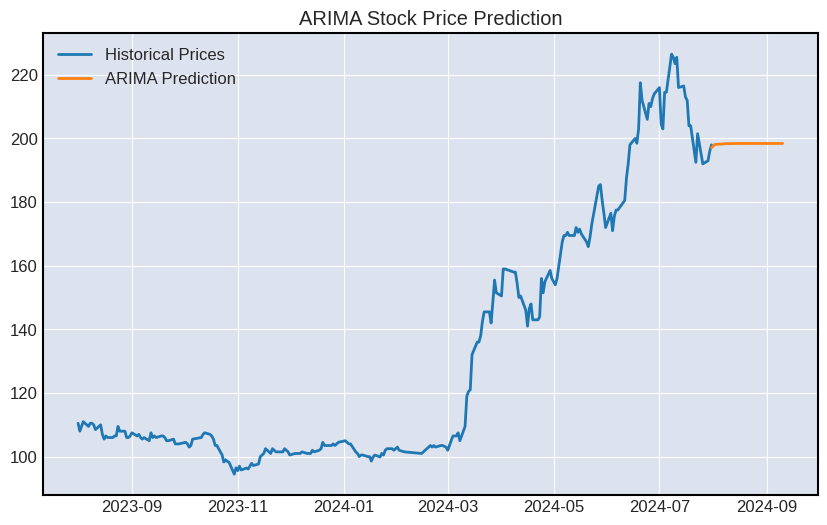

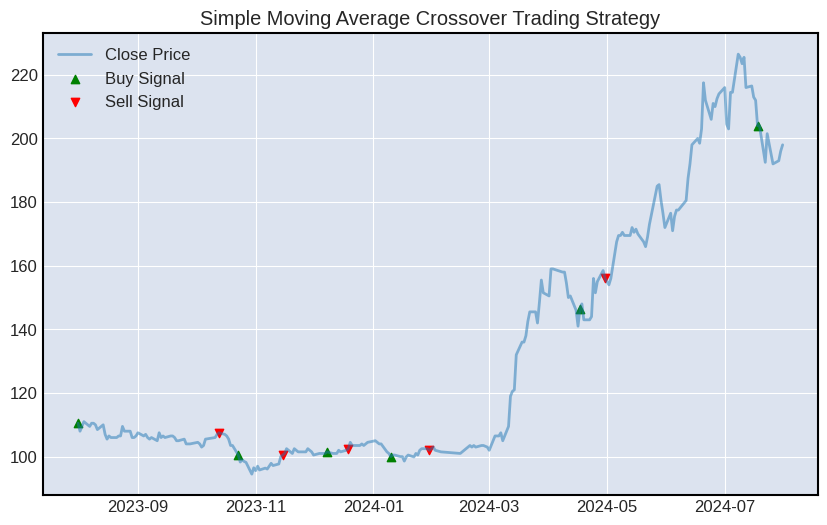

Buy at 2023-08-01 00:00:00, Price: 110.50, Position: 904.98
Sell at 2023-10-13 00:00:00, Price: 107.50, Balance: 97285.07
Buy at 2023-10-23 00:00:00, Price: 100.50, Position: 968.01
Sell at 2023-11-15 00:00:00, Price: 100.50, Balance: 97285.07
Buy at 2023-12-08 00:00:00, Price: 101.50, Position: 958.47
Sell at 2023-12-19 00:00:00, Price: 102.50, Balance: 98243.54
Buy at 2024-01-10 00:00:00, Price: 100.00, Position: 982.44
Sell at 2024-01-30 00:00:00, Price: 102.00, Balance: 100208.41
Buy at 2024-04-17 00:00:00, Price: 146.50, Position: 684.02
Sell at 2024-04-30 00:00:00, Price: 156.00, Balance: 106706.57
Buy at 2024-07-18 00:00:00, Price: 204.00, Position: 523.07
Final portfolio value: 103568.14


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import mplfinance as mpf


data = yf.download('2317.TW', start='2023-08-01', end='2024-08-01')

# 計算技術指標（SMA、EMA、MACD）
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

# 補齊缺失值
data['SMA_20'] = data['SMA_20'].fillna(data['SMA_20'].mean())
data['MACD'] = data['MACD'].fillna(data['MACD'].mean())


# 設置ARIMA模型參數
model = ARIMA(data['Close'], order=(5, 1, 0))  # (p,d,q)
arima_model = model.fit()

# ARIMA模型預測未來30天股價
pred = arima_model.predict(start=len(data), end=len(data)+29, typ='levels')  # 預測未來30天的股價


plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Historical Prices')
plt.plot(pd.date_range(start=data.index[-1], periods=30, freq='B'), pred, label='ARIMA Prediction')
plt.title('ARIMA Stock Price Prediction')
plt.legend()
plt.show()

# 設計簡單均線交叉交易策略
def trading_strategy(data):
    buy_signals = []
    sell_signals = []
    position = 0  # 0 表示空倉，1 表示持有多頭倉位

    for i in range(len(data)):
        if data['SMA_20'].iloc[i] > data['EMA_12'].iloc[i] and position == 0:
            buy_signals.append(data['Close'].iloc[i])
            sell_signals.append(np.nan)
            position = 1  # 買入
        elif data['SMA_20'].iloc[i] < data['EMA_12'].iloc[i] and position == 1:
            buy_signals.append(np.nan)
            sell_signals.append(data['Close'].iloc[i])
            position = 0  # 賣出
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    return buy_signals, sell_signals

# 生成買賣訊號
data['Buy_Signal'], data['Sell_Signal'] = trading_strategy(data)

# 可視化買賣訊號
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.scatter(data.index, data['Buy_Signal'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(data.index, data['Sell_Signal'], label='Sell Signal', marker='v', color='red', alpha=1)
plt.title('Simple Moving Average Crossover Trading Strategy')
plt.legend()
plt.show()

def backtest_strategy(data):
    initial_balance = 100000  # 初始資金
    balance = initial_balance
    position = 0  # 持倉數量
    in_position = False  # 是否有持倉

    for i in range(len(data)):
        # 如果有買入訊號，並且當前沒有持倉
        if not np.isnan(data['Buy_Signal'].iloc[i]) and not in_position:
            position = balance / data['Close'].iloc[i]  # 用全部資金買入
            balance = 0  # 資金轉換為持倉
            in_position = True  # 標記有持倉
            print(f"Buy at {data.index[i]}, Price: {data['Close'].iloc[i]:.2f}, Position: {position:.2f}")

        # 如果有賣出訊號，並且當前有持倉
        elif not np.isnan(data['Sell_Signal'].iloc[i]) and in_position:
            balance = position * data['Close'].iloc[i]  # 賣出全部持倉，獲得現金
            position = 0  # 清空持倉
            in_position = False  # 標記無持倉
            print(f"Sell at {data.index[i]}, Price: {data['Close'].iloc[i]:.2f}, Balance: {balance:.2f}")

    # 最後如果仍有持倉，按最後的價格結算
    if in_position:
        balance = position * data['Close'].iloc[-1]  # 用最後一天的價格賣出

    return balance

# 執行回測
final_balance = backtest_strategy(data)
print(f'Final portfolio value: {final_balance:.2f}')